<a href="https://colab.research.google.com/github/gheesung/sentimentanalysis/blob/master/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simple text classification

This project is to classify the twitter text to 13 sentiments. The data is obtained from [Figure Eight](https://www.figure-eight.com/data-for-everyone/). This project uses simple character CNN model to learn the emotion. 

I have kept the prediction model the same ie cnn but change to using 3 different type of optimizers, SGD, RMSProp and Adam.


### Acknowledgement
Part of the code is from the book **Deep Learning Cookbook by Douwe Osinga** 


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K

import tensorflow as tf
import numpy as np

import pandas as pd


In [0]:
! wget -qq https://www.crowdflower.com/wp-content/uploads/2016/07/text_emotion.csv

In [5]:
!ls

sample_data  text_emotion.csv  text_emotion.csv.1


In [0]:
emotion_df = pd.read_csv('./text_emotion.csv')

In [5]:
emotion_df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [8]:
emotion_df['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

##

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

VOCAB_SIZE = 50000

tfidf_vec = TfidfVectorizer(max_features=VOCAB_SIZE, analyzer='word',stop_words='english')
label_encoder = LabelEncoder()

X = tfidf_vec.fit_transform(emotion_df['content'])
y = label_encoder.fit_transform(emotion_df['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(26800, 47917) (13200, 47917) (26800,) (13200,)


In [10]:
from itertools import chain
from keras.preprocessing.sequence import pad_sequences

chars = list(sorted(set(chain(*emotion_df['content']))))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
max_sequence_len = max(len(x) for x in emotion_df['content'])

char_vectors = []
for txt in emotion_df['content']:
    vec = np.zeros((max_sequence_len, len(char_to_idx)))
    vec[np.arange(len(txt)), [char_to_idx[ch] for ch in txt]] = 1
    char_vectors.append(vec)

# convert inputs as array
char_vectors = np.asarray(char_vectors)
char_vectors = pad_sequences(char_vectors)
labels = label_encoder.transform(emotion_df['sentiment'])
print (labels)

def split(lst):
    training_count = int(0.8 * len(char_vectors))
    return lst[:training_count], lst[training_count:]

training_char_vectors, test_char_vectors = split(char_vectors)
training_labels, test_labels = split(labels)

char_vectors.shape

[ 2 10 10 ...  7  5  7]


(40000, 167, 100)

In [10]:
print (max_sequence_len, len(char_to_idx))

167 100


In [0]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

In [0]:
from keras.optimizers import Adam, SGD, RMSprop
# optimizer
learning_rate = 0.001 

opt = SGD(lr=learning_rate)

In [16]:
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Add, concatenate , LSTM
from keras.models import Model
#from keras.layers.merge import Concatenate

def create_char_cnn_model(num_chars, max_sequence_len, num_labels, optimizer):
    char_input = Input(shape=(max_sequence_len, num_chars), name='input')
    
    conv_1x = Conv1D(128, 6, activation='relu', padding='valid')(char_input)
    max_pool_1x = MaxPooling1D(6)(conv_1x)
    #dropout_1x = Dropout(0.3)(max_pool_1x)
    conv_2x = Conv1D(256, 6, activation='relu', padding='valid')(max_pool_1x)
    max_pool_2x = MaxPooling1D(6)(conv_2x)
    dropout_2x = Dropout(0.3)(max_pool_2x)
    flatten = Flatten()(dropout_2x)
    dense = Dense(128, 
                  activation='relu',
                  kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))(flatten)
    preds = Dense(num_labels, activation='softmax')(dense)

    model = Model(char_input, preds)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

# test the model using SGD optimizer
char_cnn_model_SGD = create_char_cnn_model(len(char_to_idx), char_vectors.shape[1], len(label_encoder.classes_), opt)
char_cnn_model_SGD.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 167, 100)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 162, 128)          76928     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 22, 256)           196864    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 3, 256)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 256)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 768)               0         
__________

In [17]:
history= char_cnn_model_SGD.fit(training_char_vectors, training_labels, epochs=100, batch_size=1024, validation_data=(test_char_vectors, test_labels))
char_cnn_model_SGD.evaluate(test_char_vectors, test_labels)


Train on 32000 samples, validate on 8000 samples
Epoch 1/100
32000/32000 [==============================] - 5s 169us/step - loss: 3.6400 - acc: 0.1269 - val_loss: 3.6241 - val_acc: 0.1168
Epoch 2/100
32000/32000 [==============================] - 5s 147us/step - loss: 3.6208 - acc: 0.1500 - val_loss: 3.6098 - val_acc: 0.1314
Epoch 3/100
32000/32000 [==============================] - 5s 146us/step - loss: 3.6029 - acc: 0.1650 - val_loss: 3.5964 - val_acc: 0.1547
Epoch 4/100
32000/32000 [==============================] - 5s 147us/step - loss: 3.5850 - acc: 0.1778 - val_loss: 3.5839 - val_acc: 0.1801
Epoch 5/100
32000/32000 [==============================] - 5s 147us/step - loss: 3.5689 - acc: 0.1841 - val_loss: 3.5721 - val_acc: 0.1983
Epoch 6/100
32000/32000 [==============================] - 5s 149us/step - loss: 3.5525 - acc: 0.1927 - val_loss: 3.5611 - val_acc: 0.2084
Epoch 7/100
32000/32000 [==============================] - 5s 159us/step - loss: 3.5360 - acc: 0.1927 - val_loss: 3.5

[3.342636160850525, 0.17625]

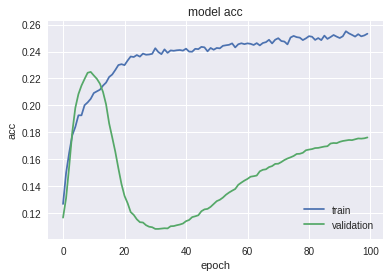

In [18]:
plot_train(history)

In [19]:
# test using RMSsprop
opt = RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0.0)

char_cnn_model_RMS = create_char_cnn_model(len(char_to_idx), char_vectors.shape[1], len(label_encoder.classes_), opt)
char_cnn_model_RMS.summary()
history= char_cnn_model_RMS.fit(training_char_vectors, training_labels, epochs=100, batch_size=1024, validation_data=(test_char_vectors, test_labels))
char_cnn_model_RMS.evaluate(test_char_vectors, test_labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 167, 100)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 162, 128)          76928     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 22, 256)           196864    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 3, 256)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 256)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 768)               0         
__________

[3.052228705406189, 0.301375]

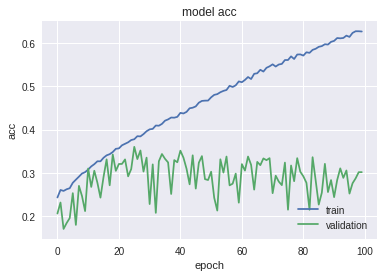

In [20]:
plot_train(history)

In [21]:
# test using Adam
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

char_cnn_model_ADAM = create_char_cnn_model(len(char_to_idx), char_vectors.shape[1], len(label_encoder.classes_), opt)
char_cnn_model_ADAM.summary()
history= char_cnn_model_ADAM.fit(training_char_vectors, training_labels, epochs=100, batch_size=1024, validation_data=(test_char_vectors, test_labels))
char_cnn_model_ADAM.evaluate(test_char_vectors, test_labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 167, 100)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 162, 128)          76928     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 22, 256)           196864    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 3, 256)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 256)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 768)               0         
__________

[4.553465565681457, 0.254]

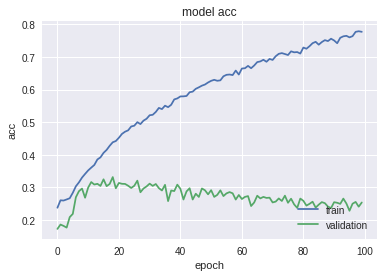

In [22]:
plot_train(history)

In [23]:
training_count = int(0.9 * len(char_vectors))

predictions = {
    'char_cnn_SGD': char_cnn_model_SGD.predict(test_char_vectors[:100]),
    'char_cnn_RMS': char_cnn_model_RMS.predict(test_char_vectors[:100]),
    'char_cnn_ADAM': char_cnn_model_ADAM.predict(test_char_vectors[:100]),
}

pd.options.display.max_colwidth = 128
test_df = emotion_df[training_count:training_count+100].reset_index()
eval_df = pd.DataFrame({
    'content': test_df['content'],
    'true': test_df['sentiment'],
    'char_cnn_SGD': [label_encoder.classes_[np.argmax(x)] for x in predictions['char_cnn_SGD']],    
    'char_cnn_RMS': [label_encoder.classes_[np.argmax(x)] for x in predictions['char_cnn_RMS']],    
    'char_cnn_ADAM': [label_encoder.classes_[np.argmax(x)] for x in predictions['char_cnn_ADAM']],        
})
eval_df = eval_df[['content', 'true', 'char_cnn_SGD', 'char_cnn_RMS','char_cnn_ADAM']]
eval_df.head(100)

,content,true,char_cnn_SGD,char_cnn_RMS,char_cnn_ADAM
0,HAPPY MOTHER'S DAY to all of the wonderful women out there. Have a great and relaxful day.,happiness,worry,surprise,happiness
1,"browsing thru adopting agencies, i'm gonna get some exotic kids",enthusiasm,neutral,neutral,neutral
2,"I am tired of my phone. Walkman works like a charm, but l need better video and wap really. Thanks for yesterday and for buy...",love,worry,neutral,neutral
3,Happy Mother's Day to all the Mommiessss,love,worry,neutral,neutral
4,@mattgarner haha what's up Matt ?,happiness,worry,worry,relief
5,What's up!!? @guillermop,neutral,worry,love,happiness
6,@KandyBee we shuld do a dance like that its seriously the best thing haha. see yu tomoro.,fun,worry,worry,neutral
7,@TravelTweetie I will go to sleep now. Might be awakened early w/breakfast tray from my 'spark' &amp; my 'joper' w/their Dad...,happiness,worry,happiness,neutral
8,@nak1a &quot;If there's a camel up a hill&quot; and &quot;I'll give you plankton&quot; ....HILARIOUS!!,happiness,neutral,surprise,neutral
9,@Bern_morley LOL I love your kids,love,worry,worry,neutral


# Observations

CNN may not be the good model for text classification but it was tried as an exercise to understand CNN. In the assignment, I have used 3 types of optimisation, SGD, RMSProp and Adam. The results are as shown above. 

In term of  accuracy with 100 epochs, RMSProp (30.17%) seems to be the best, followed by Adam (25.4%) and SGD (17.63%).

There seem be a overfitting of test data.I have tried introducng dropout but it doesn't seem to improve for all the 3 scenario.